# 🤗 HuggingFace Neural Network Notebook

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Import Libraries

In [2]:
import gc
import os
import random
import time
from typing import Tuple, List
import warnings

from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../")
warnings.simplefilter('ignore')

### Paths

In [4]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir"
    model_path: str = os.path.join(output_path, "{model_name}_fold_{fold}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    oof_path: str = os.path.join(output_path, "valid_df_fold_{fold}.csv")

### Configurations

In [5]:
DEBUG = True

In [6]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-xsmall"
    do_sliding_window: bool = True
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    lr: float = 1e-5
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 4
    num_workers: int = 6
    regression: bool = True
    seed: int = 29
    stride_length: int = 384
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0.01
    train_folds: List[int] = list(range(num_folds))

In [7]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

In [8]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [9]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

## Data Preparation

### Tokenizer

In [10]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "label": [s for s in df["label"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer_config.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/special_tokens_map.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/spm.model',
 'output/model_dir/deberta-v3-xsmall_tokenizer/added_tokens.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `labels` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [12]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["label"] = data["score"].map(lambda x: x- 1)

if CFG.regression:
    data["label"] = data["label"].astype(pd.Float32Dtype())
else:
    data["label"] = data["label"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### CV Fold Generation

Split training data into `CFG.num_folds` number of distinct CV folds.

In [13]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["label"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head()

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,0.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,1.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,4,2.0,6.0


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [14]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [15]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [16]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [17]:
if CFG.do_sliding_window:
    data = sliding_window(data, tokenizer)
    data.head(3)

100%|██████████| 17307/17307 [00:30<00:00, 565.54it/s]


,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,3.0
1,000d118,"sold a car to move there. Street parkig,drivew...",3,5,2.0,3.0
2,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,0.0


## Metrics

### QWK Score Calculation

In [18]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [19]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

## Training

### Training Arguments

In [20]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    fp16=True,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    lr_scheduler_type="linear",
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="none",
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
)

### Utility Functions

In [21]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold]
    valid = data[data["fold"] == fold].copy()
    return train, valid

In [22]:
def tokenize_data(train: pd.DataFrame, valid: pd.DataFrame) -> Tuple[Dataset, Dataset]:
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenized_train, tokenized_valid

In [23]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if CFG.regression:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [24]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [25]:
def get_metric_function():
    if CFG.regression:
        compute_metrics = compute_metrics_for_regression
    else:
        compute_metrics = compute_metrics_for_classification

    return compute_metrics

In [26]:
def post_process_predictions(predictions0):
    if CFG.regression:
        predictions = predictions0.round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions + 1

In [27]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(1, 7)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
    )
    draw_cm.plot()
    plt.show()

In [28]:
def save_model_and_tokenizer(fold: int, trainer: Trainer):
    trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME, fold=fold))

In [29]:
def save_oof_predictions(fold, valid, predictions0):
    if CFG.regression:
        valid["pred"] = predictions0 + 1
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = predictions0

    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)

### Training Fold Loop

Map:   0%|          | 0/20196 [00:00<?, ? examples/s]

Map:   0%|          | 0/2551 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/632 [00:00<?, ?it/s]

{'loss': 7.6112, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 5.0136, 'grad_norm': 26.90973663330078, 'learning_rate': 9.376000000000001e-06, 'epoch': 0.08}
{'loss': 1.4079, 'grad_norm': 10.819866180419922, 'learning_rate': 8.576e-06, 'epoch': 0.16}
{'loss': 0.6099, 'grad_norm': 26.360309600830078, 'learning_rate': 7.776e-06, 'epoch': 0.24}
{'loss': 0.5384, 'grad_norm': 7.818140506744385, 'learning_rate': 6.976000000000001e-06, 'epoch': 0.32}
{'loss': 0.5162, 'grad_norm': 6.238893985748291, 'learning_rate': 6.176000000000001e-06, 'epoch': 0.4}
{'loss': 0.5153, 'grad_norm': 15.320359230041504, 'learning_rate': 5.376e-06, 'epoch': 0.47}
{'loss': 0.5162, 'grad_norm': 21.958295822143555, 'learning_rate': 4.576000000000001e-06, 'epoch': 0.55}
{'loss': 0.4658, 'grad_norm': 8.686038970947266, 'learning_rate': 3.7760000000000004e-06, 'epoch': 0.63}
{'loss': 0.4573, 'grad_norm': 17.940837860107422, 'learning_rate': 2.976e-06, 'epoch': 0.71}
{'loss': 0.436, 'grad_norm': 15.7535

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.7276452779769897, 'eval_qwk': 0.5569552203835979, 'eval_runtime': 7.5986, 'eval_samples_per_second': 335.719, 'eval_steps_per_second': 10.528, 'epoch': 1.0}
{'train_runtime': 214.5162, 'train_samples_per_second': 94.147, 'train_steps_per_second': 2.946, 'train_loss': 0.9215077539033527, 'epoch': 1.0}


  0%|          | 0/80 [00:00<?, ?it/s]

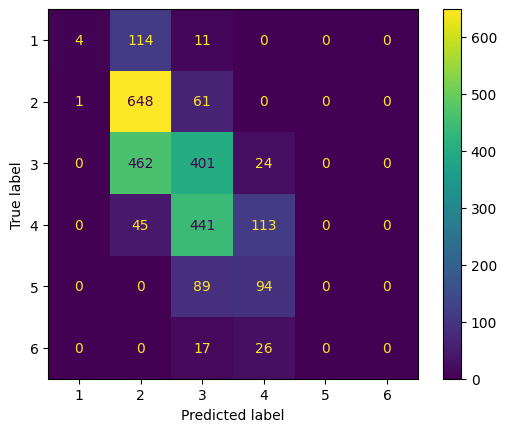

In [30]:
for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=get_metric_function(),
    )

    trainer.train()

    y_true = valid["score"].values
    predictions0 = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(predictions0)

    plot_confusion_matrxi(y_true, y_pred)

    save_model_and_tokenizer(fold, trainer)

    save_oof_predictions(fold, valid, predictions0)

    del (
        train,
        valid,
        tokenized_train,
        tokenized_valid,
        backbone_model,
        data_collator,
        trainer,
        y_pred,
        y_true,
        predictions0,
    )
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)